In [252]:
import gc
import torch
from tqdm import tqdm

from predict import compute_gradient_direction
from training import kp_loss
from utils import imshow, save_model,create_circular_mask
from config import device, args
from training.tensor_augmetation import random_augmentation, shifted_batch_tensor


In [253]:
import time
#create function to calcule time of code
def time_code(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return int(hours), int(minutes), seconds

In [254]:

def train_one_epoch(model, loader, optimizer, criterion_d ,criterion_o, epoch, is_show=True):
    model.train()
    running_loss = 0.
    qtd_batch = len(loader)
    t = tqdm(loader, desc="Train Epoch:{} ".format(epoch))
    for batch_idx, (batch_image, labels) in enumerate(t):
        loss1 = 0
        loss2 = 0

        start = time.time()

        batch_image = batch_image.to(device)
        _kp1, _orie1 = model(batch_image)


        _B, _C, _W, _H = batch_image.shape
        SIZE_BORDER = args.border_size
        batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
        batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1

        print(_kp1.shape, _orie1.shape, batch_mask.shape, img_batch.shape)
        batch_image_pos_trans, feature_kp_anchor_trans, features_ori_anchor_trans,mask_trans = random_augmentation(
            batch_image,
            _kp1, _orie1,batch_mask)

        _kp2_pos, _orie2_pos = model(batch_image_pos_trans)
        batch_image_neg_trans, _kp2_neg, _orie2_neg = shifted_batch_tensor(batch_image_pos_trans, _kp2_pos,
                                                                           _orie2_pos)  # faz o shift com o comando roll(x,1,0)
        end = time.time()
        hours, minutes, seconds = time_code(start, end)
        # print("Tempo de execução predict : {:0>2}:{:0>2}:{:05.2f}".format(hours,minutes,seconds))
        # start = end

        if is_show and batch_idx % 25 == 0:
            temp = torch.cat([batch_image_pos_trans[3], batch_image_pos_trans[3] * mask_trans[3],
                              batch_image_neg_trans[3] * mask_trans[3]], dim=-1)
            imshow(temp)
            temp = torch.cat([feature_kp_anchor_trans[3] * mask_trans[3], _kp2_pos[3] * mask_trans[3],
                              _kp2_neg[3] * mask_trans[3]], dim=-1)
            imshow(temp)
            fo2 = features_ori_anchor_trans*mask_trans
            fo2 = compute_gradient_direction(fo2)

            op2 = _orie2_pos*mask_trans
            op2 = compute_gradient_direction(op2)

            on2 = _orie2_neg*mask_trans
            on2 = compute_gradient_direction(on2)
            temp = torch.cat([fo2[3],op2[3],on2[3]], dim=-1)[None]
            imshow(temp)

        loss1 = criterion_d(feature_kp_anchor_trans*mask_trans, _kp2_pos*mask_trans, _kp2_neg*mask_trans)

        if isinstance(criterion_o, kp_loss):
            loss2 = criterion_o(features_ori_anchor_trans * mask_trans, _orie2_pos * mask_trans)
        else:
            loss2 = criterion_o(features_ori_anchor_trans * mask_trans, _orie2_pos * mask_trans, _orie2_neg * mask_trans)

        loss = loss1 + loss2


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        try:
            running_loss += (loss.item()/qtd_batch)
        except AttributeError:
            print('AttributeError ', type(loss), loss)

        t.set_description("Train Epoch:{} Loss: {:.5f}".format(epoch, running_loss))


        del batch_image
        del batch_image_neg_trans
        del _kp1, _kp2_pos, _kp2_neg, _orie1, _orie2_pos, _orie2_neg
        gc.collect()
        torch.cuda.empty_cache()

    model.eval()
    # print('Train Epoch: {} \tLoss: {:.15f}'.format(
    #     epoch, running_loss))
    return running_loss


In [255]:
from torchvision.transforms import transforms, InterpolationMode
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

torch.manual_seed(42)
torch.cuda.manual_seed(42)

MODEL_PATH = "./data/models/model_{}.pt".format("flowers_ssim_teste")
print(MODEL_PATH)
args.img_size = 170
args.dim_first = 2
args.dim_second = 3
args.dim_third = 4
args.batch_size = 11
args.is_loss_ssim = True


transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)

./data/models/model_flowers_ssim_teste.pt


c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Não foi treinado ainda


Train Epoch:0 :   0%|          | 0/93 [00:00<?, ?it/s]

torch.Size([11, 1, 170, 170]) torch.Size([11, 36, 170, 170]) torch.Size([11, 1, 170, 170]) torch.Size([11, 3, 170, 170])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


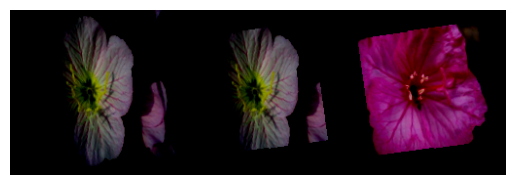

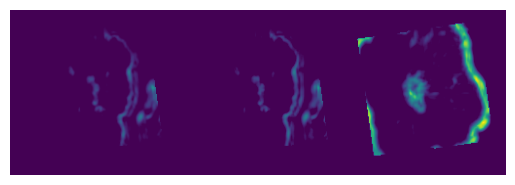

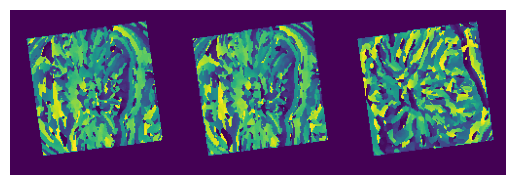

Train Epoch:0 Loss: 0.01941:   1%|          | 1/93 [00:08<12:48,  8.36s/it]

torch.Size([11, 1, 170, 170]) torch.Size([11, 36, 170, 170]) torch.Size([11, 1, 170, 170]) torch.Size([11, 3, 170, 170])


Train Epoch:0 Loss: 0.03892:   2%|▏         | 2/93 [00:10<07:29,  4.94s/it]

torch.Size([11, 1, 170, 170]) torch.Size([11, 36, 170, 170]) torch.Size([11, 1, 170, 170]) torch.Size([11, 3, 170, 170])


Train Epoch:0 Loss: 0.05815:   3%|▎         | 3/93 [00:13<05:45,  3.84s/it]

torch.Size([11, 1, 170, 170]) torch.Size([11, 36, 170, 170]) torch.Size([11, 1, 170, 170]) torch.Size([11, 3, 170, 170])


Train Epoch:0 Loss: 0.07760:   4%|▍         | 4/93 [00:15<04:56,  3.33s/it]

torch.Size([11, 1, 170, 170]) torch.Size([11, 36, 170, 170]) torch.Size([11, 1, 170, 170]) torch.Size([11, 3, 170, 170])


Train Epoch:0 Loss: 0.07760:   4%|▍         | 4/93 [00:17<06:36,  4.46s/it]


KeyboardInterrupt: 

In [256]:
from training import KeyEqGroup
from utils import load_model,save_model
from training import KeyEqGroup,kp_loss as simple_loss,triplet_loss as loss_function

model = KeyEqGroup(args).to(device)
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.75)

try:
    model, optimizer, i_epoch, loss = load_model(model, optimizer, path=MODEL_PATH)
    print("Já foi treinado")
    print("epoca {} loss {}".format(i_epoch, loss))
except:
    print("Não foi treinado ainda")


for epoch in range(i_epoch, args.epochs):
    criterion_d = loss_function(is_ssim=args.is_loss_ssim, margim=args.margin_loss)
    # criterion_o = loss_function(is_ssim=args.is_loss_ssim, margim=args.margin_loss)
    criterion_o = simple_loss()
    running_loss = train_one_epoch(model, trainloader, optimizer=optimizer, criterion_d=criterion_d,criterion_o=criterion_o,epoch=epoch, is_show=True)
    
    valid_loss =running_loss
    # valid_loss = test(model, testloader, criterion=criterion_d,epoch=epoch)
    if (epoch % 5 == 0) and (epoch != 0):
        scheduler.step()
    print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])

    if valid_loss <= 0.0:
        break

In [ ]:
import matplotlib.pyplot as plt
#function plot imagem and coords
def plot_image_and_coords(image, coords):
    plt.imshow(image)
    for i, (y,x) in enumerate(coords):
        plt.plot(x, y, '.',markerfacecolor='none', markeredgecolor='r',
                markersize=10, markeredgewidth=1)
    plt.show()
    

pontos detectados do batch  torch.Size([1716, 5])  pontos de uma imagem torch.Size([55, 3])


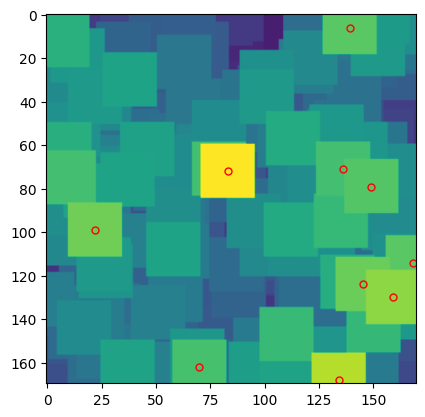

tensor([[ 72.0000,  83.0000,   3.9526],
        [168.0000, 134.0000,   3.7325],
        [130.0000, 159.0000,   3.6145],
        [ 99.0000,  22.0000,   3.5228],
        [124.0000, 145.0000,   3.5073],
        [114.0000, 168.0000,   3.4455],
        [  6.0000, 139.0000,   3.4421],
        [ 79.0000, 149.0000,   3.4204],
        [162.0000,  70.0000,   3.3791],
        [ 71.0000, 136.0000,   3.3644]])

In [ ]:
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        """
        Detects the maximum points in a batch of images.

        Args:
        - images: Tensor with dimensions [b, channel, height, width] containing the images.
        - size: Size of the maximum filter.
        - threshold: Threshold to consider a point as maximum.

        Returns:
        - max_coords_values: Tensor containing the coordinates of the maximum points along with the corresponding scalar values.
        - max_map: Tensor containing the resulting maximum map.
        """
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()

        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]
        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)

        return max_coords_values, max_map.squeeze().numpy()

    def filter_coordinates(self, tensor, image_index, channel_index):
        """
        Filters coordinates in a tensor based on the image and channel indices.

        Args:
        - tensor: Tensor with dimensions [b, channel, x, y] containing the data.
        - image_index: Image index to filter the coordinates.
        - channel_index: Channel index to filter the coordinates.

        Returns:
        - filtered_coords: Tensor containing the filtered coordinates.
        """
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)

        return filtered_coords

    def sort_matrix_by_last_element(self, matrix):
        """
        Sorts the rows of a matrix based on the last element of each row.

        Args:
        - matrix: NumPy array representing the matrix.

        Returns:
        - sorted_matrix: NumPy array with sorted rows in descending order based on the last element.
        """
        indices = np.argsort(-matrix[:, -1])  # Sort based on the last column
        sorted_matrix = matrix[indices]

        return sorted_matrix


# Exemplo de uso
detector = MaxPointDetector()
# Chamando o método max_filtering
batch = torch.randn(11, 3, 170, 170)  # Exemplo de batch com 11 imagens

max_coords_values, max_map = detector.detect_max_points(batch, size=25, threshold=1e-3)
valores_filtrados = detector.filter_coordinates(max_coords_values, image_index=0, channel_index=0)
valores_ordenados = detector.sort_matrix_by_last_element(valores_filtrados)

print('pontos detectados do batch ',max_coords_values.shape,' pontos de uma imagem',valores_filtrados.shape)
plot_image_and_coords(max_map[0,0], valores_ordenados[:10, 0:2])
valores_ordenados[:10]

torch.Size([11, 1, 170, 170]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pontos detectados do batch  torch.Size([565, 5])  pontos de uma imagem torch.Size([30, 3]) (11, 170, 170)


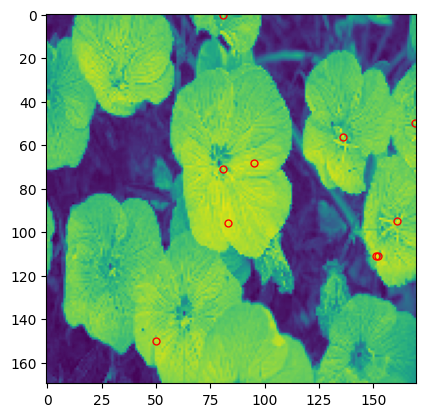

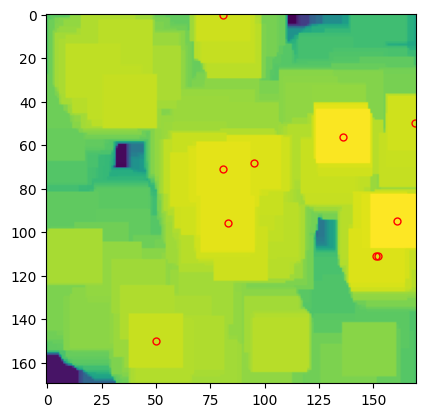

tensor([[ 95.0000, 161.0000,   0.7255],
        [ 56.0000, 136.0000,   0.7176],
        [ 96.0000,  83.0000,   0.6706],
        [ 71.0000,  81.0000,   0.6706],
        [111.0000, 152.0000,   0.6549],
        [111.0000, 151.0000,   0.6549],
        [ 68.0000,  95.0000,   0.6549],
        [ 50.0000, 169.0000,   0.6314],
        [  0.0000,  81.0000,   0.6235],
        [150.0000,  50.0000,   0.6157]])

In [ ]:
iterator=iter(trainloader)
batch = next(iterator)
img_batch, labels =batch
print(img_batch[:,:1,:,:].shape,labels) #4

max_coords_values, max_map = detector.detect_max_points(img_batch[:,0:1,:,:], size=25, threshold=1e-3)
valores_filtrados = detector.filter_coordinates(max_coords_values, image_index=0, channel_index=0)
valores_ordenados = detector.sort_matrix_by_last_element(valores_filtrados)
print('pontos detectados do batch ',max_coords_values.shape,' pontos de uma imagem',valores_filtrados.shape,max_map.shape)
plot_image_and_coords(img_batch[0,0], valores_ordenados[:10, 0:2])
plot_image_and_coords(max_map[0], valores_ordenados[:10, 0:2])
valores_ordenados[:10]

torch.Size([2, 1, 5, 6]) torch.Size([2, 4, 2])
torch.Size([2, 1, 5, 6]) torch.Size([2, 4, 2])
torch.Size([1, 1, 170, 170])
torch.Size([1, 1, 170, 170]) torch.Size([1, 10, 2]) (170, 170)


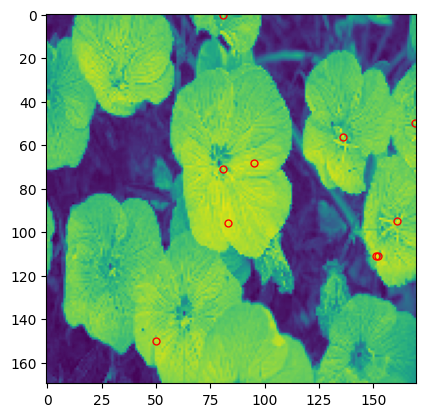

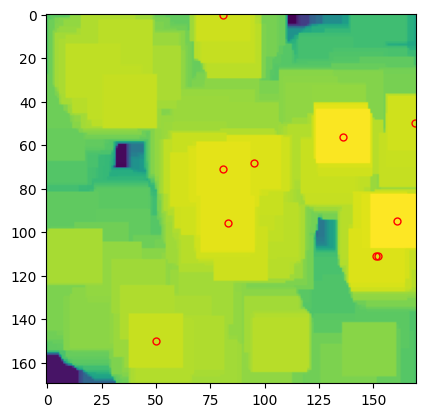

torch.Size([1, 1, 170, 170]) torch.Size([1, 10, 2]) (170, 170)


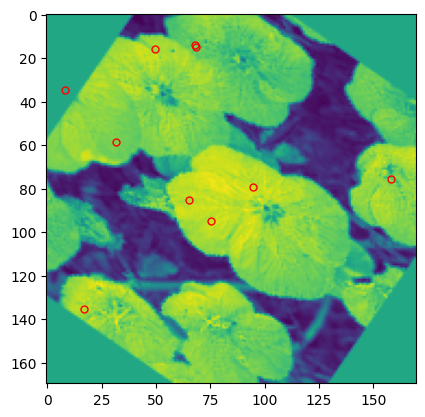

In [283]:
import kornia
import kornia.augmentation as K
input = torch.randn(2, 1, 5, 6)

points = torch.tensor([[[1., 1.],[1., 1.],[1., 1.],[1., 1.]]]).expand(2, -1, -1)

aug_list = K.AugmentationSequential(
    kornia.augmentation.RandomAffine(360, p=1.0),
    data_keys=["input","keypoints"]
)
print(input.shape,points.shape)
input_trans , points_trans = aug_list(input, points)
print(input_trans.shape,points_trans.shape)

input_batch = img_batch[:1,0:1,:,:]
print(input_batch.shape)
max_coords_values, max_map = detector.detect_max_points(input_batch, size=25, threshold=1e-3)
valores_filtrados = detector.filter_coordinates(max_coords_values, image_index=0, channel_index=0)
valores_ordenados = detector.sort_matrix_by_last_element(valores_filtrados)
points = valores_ordenados[:10,:2][None]

print(input_batch.shape,points.shape,max_map.shape)
plot_image_and_coords(input_batch[0,0], points[0])
plot_image_and_coords(max_map, points[0])

input_trans,points_trans = aug_list(input_batch, points)
print(input_batch.shape,points.shape,max_map.shape)
plot_image_and_coords(input_trans[0,0], points_trans[0])

In [ ]:
aug_list = K.AugmentationSequential(
    kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
    kornia.augmentation.RandomAffine(360, p=1.0),
    data_keys=["input", "keypoints"],
    same_on_batch=True
)